In [1]:
from pathlib import Path
import numpy as np

from my_types import Quat, ScalarBatch, QuatBatch
import lib_quat as libq
from io_csv import load_gyro_base, load_ref
from pipelines import integrate_gyro
from evaluation import calc_angle_err, print_err_status, save_err_csv, plot_err_from_csv

In [2]:
root: Path = Path.cwd().parent
#run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"
#run_dir: Path = root / "data" / "21:23_oct_07_2025_9min"
#run_dir: Path = root / "data" / "21:41_oct_07_2025_13min"
run_dir: Path = root / "data" / "18:52_oct_08_2025_96min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"

for p in [ori_path, gyro_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

# fix quaternion sign continuity
for i in range(1, len(q_ref_interp)):
        if np.dot(q_ref_interp[i - 1], q_ref_interp[i]) < 0:
                q_ref_interp[i] *= -1

In [4]:
#i: int = 0

#while i in range(len(dt)):
#        dt_tmp = dt[i:1000+i]
#        t_new_tmp = t_new[i:1000+i]
#        w_avg_gyro_tmp = w_avg_gyro[i:1000+i]
#        q_ref_interp_tmp = q_ref_interp[i:1000+i]

#        q0_tmp: Quat = q_ref_interp[i].copy()
#        q_gyro_tmp: QuatBatch = integrate_gyro(q0_tmp, w_avg_gyro_tmp, dt_tmp)
#        angle_err_tmp: ScalarBatch = calc_angle_err(q_gyro_tmp, q_ref_interp_tmp)
#        print("here: ", np.linalg.norm(angle_err_tmp, axis=0), "i: ", i)
#        if np.linalg.norm(angle_err_tmp, axis=0) < 1.5:
#                break
#        i = i + 1000

#dt = dt[i:]
#t_new = t_new[i:]
#w_avg_gyro = w_avg_gyro[i:]
#q_ref_interp = q_ref_interp[i:]

#print("i: ", i)

In [5]:
q0: Quat = q_ref_interp[0].copy()

q_gyro: QuatBatch = integrate_gyro(q0, w_avg_gyro, dt)

angle_err_gyro: ScalarBatch = calc_angle_err(q_gyro, q_ref_interp)
print_err_status("Gyro only", angle_err_gyro)

Gyro only angle error in rad — min/max/mean
0.0017503209553177612 3.1380681380116897 1.0451934334037227

Gyro only angle error in deg — min/max/mean
0.10028600353301406 179.79806013254657 59.88517250882119


In [6]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path: Path = out_dir / "01_angle_err_gyro.csv"
save_err_csv(out_path, t_new, angle_err_gyro)

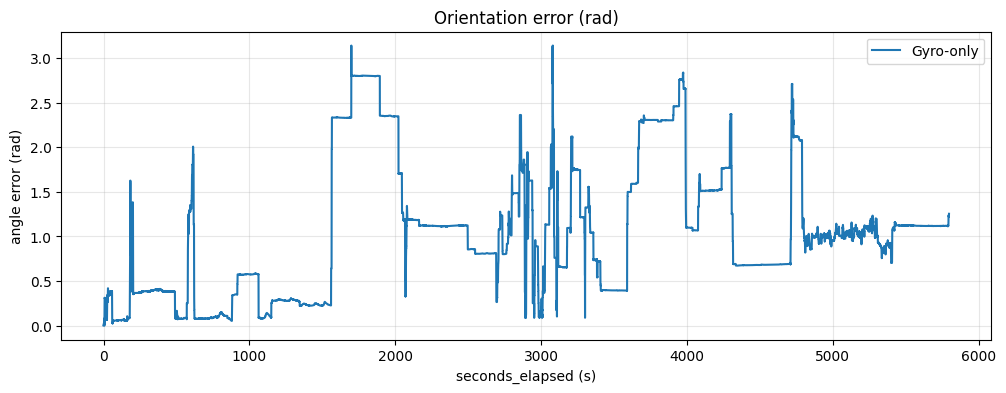

In [7]:
plot_err_from_csv([
        ("Gyro-only", out_path)
])